In [1]:
import tensorflow as tf
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
from os import path
import shutil
from keras.preprocessing.image import ImageDataGenerator
import imgaug.augmenters as iaa



dtype = torch.float
device = torch.device("cpu")

In [2]:
tf.__version__

'2.8.0'

In [3]:

#src = "chest_xray/train/PNEUMONIA"
#dst1 = "chest_xray/train/PNEUMONIA_BACTERIAL"
#dst2 = "chest_xray/train/PNEUMONIA_VIRUS"
#files_bacteria = [i for i in os.listdir(src) if "bacteria" in i and path.isfile(path.join(src, i))]
#files_virus = [i for i in os.listdir(src) if "virus" in i and path.isfile(path.join(src, i))]


#for f in files_bacteria:
 #   shutil.move(path.join(src, f), dst1)

#for f in files_virus:
 #   shutil.move(path.join(src, f), dst2)


In [4]:
#src = "chest_xray/test/PNEUMONIA"
#dst1 = "chest_xray/test/PNEUMONIA_BACTERIAL"
#dst2 = "chest_xray/test/PNEUMONIA_VIRUS"
#files_bacteria = [i for i in os.listdir(src) if "bacteria" in i and path.isfile(path.join(src, i))]
#files_virus = [i for i in os.listdir(src) if "virus" in i and path.isfile(path.join(src, i))]


#for f in files_bacteria:
 #   shutil.move(path.join(src, f), dst1)

#for f in files_virus:
 #   shutil.move(path.join(src, f), dst2)

In [5]:
data_dir = './chest_xray/train'
img_height = 180
img_width = 180
batchSize = 16

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height,img_width),
                                                       batch_size=batchSize
                                                      )


Found 5232 files belonging to 3 classes.
Using 4186 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batchSize)

Found 5232 files belonging to 3 classes.
Using 1046 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA_BACTERIAL', 'PNEUMONIA_VIRUS']


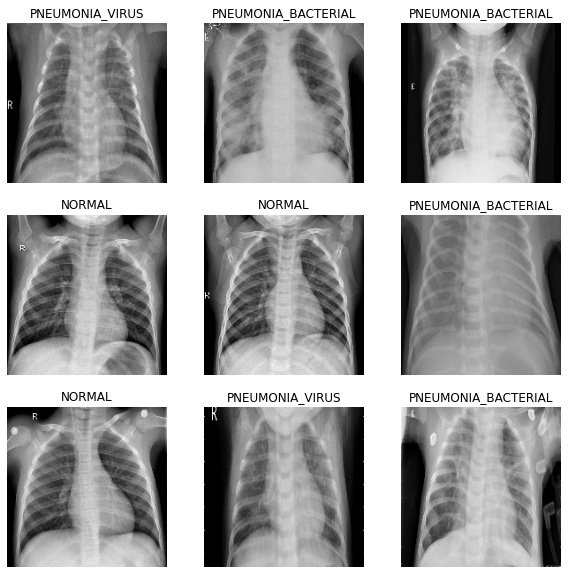

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(200).prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normal_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))#
val_normal_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
#train_ds = normal_ds
#val_ds = val_normal_ds
#image_batch, labels_batch = next(iter(train_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [13]:
data_augmentation = keras.Sequential(
  [
    #layers.RandomFlip("horizontal",input_shape=(img_height, img_width,3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
  ]
)

In [14]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (2,2), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (4,4), strides=(1, 1), padding='same'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (8,8), strides=(1, 1), padding='same'),
   layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2DTranspose(256, 3, strides=(4,4), padding='same'),
  #layers.MaxPooling2D(pool_size = (16,16), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (8,8), strides=(1, 1), padding='same'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (4,4), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (4,4), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [17]:
#tf.config.set_soft_device_placement(True) 
with tf.device('/cpu:0'):   
    epochs=100
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size = batchSize,
      shuffle = True


    )
#sess = tf.Session(config=tf.ConfigProto(
 #     allow_soft_placement=True, log_device_placement=True))

#print(sess.run(history))

Epoch 1/100
131/131 [==============================] - 120s 870ms/step - loss: 0.8658 - accuracy: 0.6405 - val_loss: 2.2517 - val_accuracy: 0.5019
Epoch 2/100
131/131 [==============================] - 112s 856ms/step - loss: 0.6794 - accuracy: 0.7040 - val_loss: 1.7043 - val_accuracy: 0.4656
Epoch 3/100
131/131 [==============================] - 113s 867ms/step - loss: 0.6439 - accuracy: 0.7238 - val_loss: 0.7241 - val_accuracy: 0.6702
Epoch 4/100
131/131 [==============================] - 113s 863ms/step - loss: 0.6225 - accuracy: 0.7324 - val_loss: 0.8524 - val_accuracy: 0.6616
Epoch 5/100
131/131 [==============================] - 114s 869ms/step - loss: 0.5946 - accuracy: 0.7473 - val_loss: 1.5726 - val_accuracy: 0.5449
Epoch 6/100
131/131 [==============================] - 113s 867ms/step - loss: 0.5868 - accuracy: 0.7544 - val_loss: 0.6114 - val_accuracy: 0.7323
Epoch 7/100
131/131 [==============================] - 114s 874ms/step - loss: 0.5655 - accuracy: 0.7570 - val_loss: 0

131/131 [==============================] - 116s 886ms/step - loss: 0.4574 - accuracy: 0.8010 - val_loss: 1.7306 - val_accuracy: 0.4971
Epoch 57/100
131/131 [==============================] - 116s 888ms/step - loss: 0.4518 - accuracy: 0.8110 - val_loss: 0.6617 - val_accuracy: 0.7314
Epoch 58/100
131/131 [==============================] - 116s 883ms/step - loss: 0.4543 - accuracy: 0.8003 - val_loss: 0.5182 - val_accuracy: 0.7772
Epoch 59/100
131/131 [==============================] - 113s 867ms/step - loss: 0.4403 - accuracy: 0.8122 - val_loss: 1.1791 - val_accuracy: 0.6453
Epoch 60/100
131/131 [==============================] - 114s 867ms/step - loss: 0.4567 - accuracy: 0.8012 - val_loss: 0.5554 - val_accuracy: 0.7648
Epoch 61/100
131/131 [==============================] - 116s 883ms/step - loss: 0.4497 - accuracy: 0.8067 - val_loss: 0.5753 - val_accuracy: 0.7581
Epoch 62/100
131/131 [==============================] - 114s 869ms/step - loss: 0.4498 - accuracy: 0.8000 - val_loss: 0.6840 

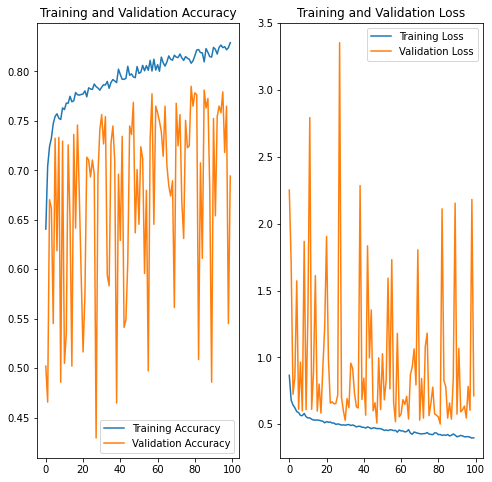

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
test_normal_path = "chest_xray/train/NORMAL/"
test_bacterial_path= "chest_xray/test/PNEUMONIA_BACTERIAL"
test_virus_path= "chest_xray/test/PNEUMONIA_VIRUS"

test_files_bacteria = [i for i in os.listdir(test_bacterial_path) if "bacteria" in i and path.isfile(path.join(test_bacterial_path, i))]
test_files_virus = [i for i in os.listdir(test_virus_path) if "virus" in i and path.isfile(path.join(test_virus_path, i))]
test_files_normal = [i for i in os.listdir(test_normal_path) if "NORMAL" in i and path.isfile(path.join(test_normal_path, i))]
img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[0]), target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch



In [20]:
count = 0
for index in range(len(test_files_normal)):
    img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "NORMAL":
        count+=1

        
print("Accuracy for normal = ", count/len(test_files_normal) *100, "%")


Accuracy for normal =  85.23936170212765 %


In [21]:
count = 0
diagnosed = 0
for index in range(len(test_files_bacteria)):
    img = tf.keras.utils.load_img(
    path.join(test_bacterial_path, test_files_bacteria[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
    

print("Accuracy for bacterial pneumonia = ", count/len(test_files_bacteria) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_bacteria) *100, "%")

Accuracy for bacterial pneumonia =  71.48760330578511 %
Accuracy for pneumonia =  98.34710743801654 %


In [22]:
count = 0
diagnosed = 0
for index in range(len(test_files_virus)):
    img = tf.keras.utils.load_img(
    path.join(test_virus_path, test_files_virus[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
print("Accuracy for viral pneumonia = ", count/len(test_files_virus) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_virus) *100, "%")

Accuracy for viral pneumonia =  86.48648648648648 %
Accuracy for pneumonia =  97.97297297297297 %


In [23]:
!mkdir -p saved_model5
model.save('saved_model5/my_model')

INFO:tensorflow:Assets written to: saved_model4/my_model/assets


In [24]:
ls saved_model5/my_model

assets/            keras_metadata.pb  saved_model.pb     variables/


In [25]:
new_model = tf.keras.models.load_model('saved_model4/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)       

## First model batchsize = 64, dropout = 0.5
## Second model batchsize = 32, dropout =0.2
## Thrid model batchsize = 32, dropout =0.2
## Forth model batchsize = 32, dropout =0.2

In [26]:
count = 0
diagnosed = 0
for index in range(len(test_files_virus)):
    img = tf.keras.utils.load_img(
    path.join(test_virus_path, test_files_virus[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = new_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
print("Accuracy for viral pneumonia = ", count/len(test_files_virus) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_virus) *100, "%")

Accuracy for viral pneumonia =  86.48648648648648 %
Accuracy for pneumonia =  97.97297297297297 %
